> This notebook was originally published on https://www.kaggle.com/joatom/model-allocation.


In this notebook I experiment with two ensembling strategies.

There are many ways to combine different models to improve predictions. A common technique for regression tasks is taking a weighted average of the model predictions (`y_pred = (m1(x)*w1 + ... + mn(x)*wn) / n`). Another common technique is building a meta model, that is trained on the models' outputs.

The first chapter starts with a simple linear combination of two models. And we explore with an simple example, why ensembling actually works. These insights will lead, in the second chapter, to the first technique on how to choose weights for a linear ensemble by using residual variance. In the third chapter an alternative for the weight selection is examined. This second technique is inspired by portfolio theory (a theory to combine financial assets). In the fourth chapter the two techniques are applied and compared on the  [Tabular Playground Series (TPS) - Aug 2021](https://www.kaggle.com/c/tabular-playground-series-aug-2021) competition. Finaly cross validation (CV) and leaderboard (LB) Scores are listed in the fith chapter.

:::{.callout-note}
For the ease of explanation we make some simplifying assumptions, such as equal distribution of the data, same distribution on unseen data, ... (just think of a vanilla world).
:::

In [1]:
#|include: false

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, ARDRegression, PoissonRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor

import scipy.optimize

from xgboost import XGBRegressor

from tqdm import tqdm

# 1. Why ensembling works

Suppose there are two fitted regression models and they predict values like shown in the first chart.

In [2]:
#|include: false

x = np.linspace(1,7,7)

y_true = np.array([5, 4, 8, 6, 5, 4, 5])
m1 =     np.array([7, 3, 9, 5, 6, 3, 3.5])
m2 =     np.array([4, 5, 8, 7, 2, 5, 6])

In [3]:
#|include: false

df = pd.DataFrame(np.array([x, m1, m2, y_true]).T, columns = ['x', 'm1', 'm2', 'y_true']).melt('x')
df.columns = ['x', 'Values', 'y']

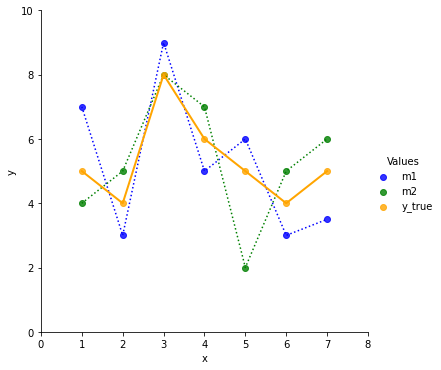

In [4]:
#|echo: false

fig = sns.lmplot(x = 'x', y= 'y', data = df, hue='Values', palette=["b", "g", "orange"], fit_reg=False )
fig.axes[0,0].plot(x, m1, linestyle='dotted', color = 'b')
fig.axes[0,0].plot(x, m2, linestyle='dotted', color = 'g')
fig.axes[0,0].plot(x, y_true, linewidth = 2, color = 'orange')

plt.xlim([0, 8])
plt.ylim([0, 10])
plt.show()

To get a better intuition on how good the two models fit the ground truth, we plot the residuals `y_true(x)-m(x)`.

In [5]:
#|include: false

m1_res = y_true - m1
m2_res = y_true - m2

df_res = pd.DataFrame(np.array([x, m1_res, m2_res]).T, columns = ['x', 'm1_res', 'm2_res']).melt('x')
df_res.columns = ['x', 'Residuals', 'y']

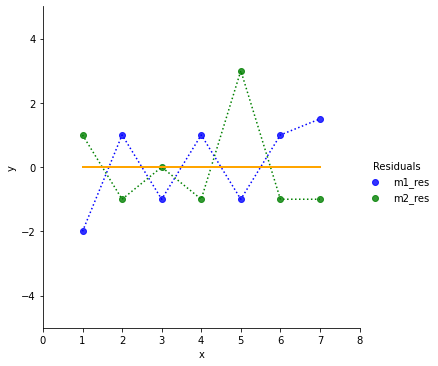

In [6]:
#|echo: false

fig = sns.lmplot(x = 'x', y= 'y', data = df_res, hue='Residuals', palette=["b", "g", "orange"], fit_reg=False )
fig.axes[0,0].plot(x, m1_res, linestyle='dotted', color = 'b')
fig.axes[0,0].plot(x, m2_res, linestyle='dotted', color = 'g')
fig.axes[0,0].plot(x, np.zeros(7), linewidth = 2, color = 'orange')

plt.xlim([0, 8])
plt.ylim([-5, 5])
plt.show()

If we had to choose one of the models, which one would we prefer? 
Model 2 does better on the first data point and perfect on the third, but it contains an outlier the 5th data point.

Let's look at the mean and the variance of the residuals.

In [7]:
#|echo: false

print(f'Model #1. mean: {m1_res.mean(): .4f}, var: {m1_res.var(): .4f}')
print(f'Model #2. mean: {m2_res.mean(): .4f}, var: {m2_res.var(): .4f}')


Model #1. mean:  0.0714, var:  1.6020
Model #2. mean:  0.0000, var:  2.0000


On the long run Model2 has an average residual of 0. Model 1 carries along a residual of 0.0714. So on average Model 2 seams to do better. 

But Model 2 also has a higher variance. That implies we have a great chance to do a great prediction (e.g. x=3) but we also have high risk to screw the prediction (e.g. x=5). 


Now we build a simple linear ensemble of the two models like `ens = 0.5 * m1 + 0.5 m2`.

In [8]:
#|include: false

ens = (m1+m2)/2

df = pd.DataFrame(np.array([x, m1, m2, ens, y_true]).T, columns = ['x', 'm1', 'm2', 'ens', 'y_true']).melt('x')
df.columns = ['x', 'Values', 'y']


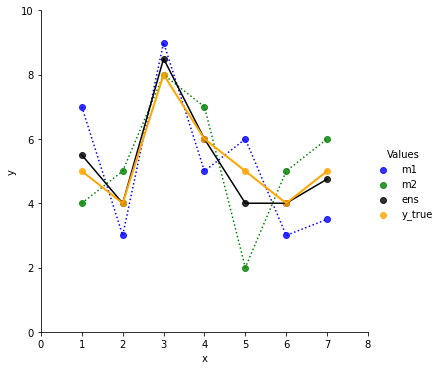

In [9]:
#|echo: false

fig = sns.lmplot(x = 'x', y= 'y', data = df, hue='Values', palette=["b", "g", "black", "orange"], fit_reg=False )
fig.axes[0,0].plot(x, m1, linestyle='dotted', color = 'b')
fig.axes[0,0].plot(x, m2, linestyle='dotted', color = 'g')
fig.axes[0,0].plot(x, ens, color = 'black')
fig.axes[0,0].plot(x, y_true, linewidth = 2, color = 'orange')

plt.xlim([0, 8])
plt.ylim([0, 10])
plt.show()

The ensemble line is closer to the true values. It also looks smoother then m1 and m2.

In [10]:
#|include: false

ens_res = y_true - ens

df_res = pd.DataFrame(np.array([x, m1_res, m2_res, ens_res]).T, columns = ['x', 'm1_res', 'm2_res', 'ens_res']).melt('x')
df_res.columns = ['x', 'Residuals', 'y']

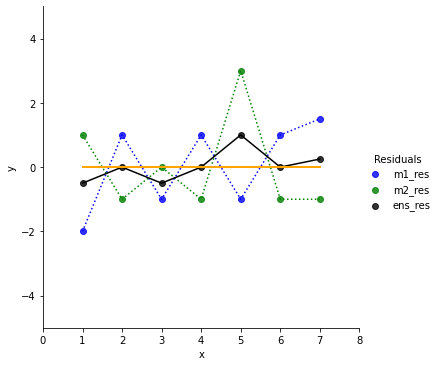

In [11]:
#|echo: false

fig = sns.lmplot(x = 'x', y= 'y', data = df_res, hue='Residuals', palette=["b", "g", "black", "orange"], fit_reg=False )
fig.axes[0,0].plot(x, m1_res, linestyle='dotted', color = 'b')
fig.axes[0,0].plot(x, m2_res, linestyle='dotted', color = 'g')
fig.axes[0,0].plot(x, ens_res, color = 'black')
fig.axes[0,0].plot(x, np.zeros(7), linewidth = 2, color = 'orange')

plt.xlim([0, 8])
plt.ylim([-5, 5])
plt.show()

In the residual chart we can see that the ensemble does a bit worse for x=3 compared to Model 2. But it also decreases the residuals for the outliers (points 1, 5, 7).

Let's check the stats:

In [12]:
#|echo: false

print(f'Ensemble. mean: {ens_res.mean(): .4f}, var: {ens_res.var(): .4f}')

Ensemble. mean:  0.0357, var:  0.2219


We dramatically reduced the variance, hence reduced the risk/chance. The mean value is now in between Model 1 and Model 2.

Finally let's play around with the model weights in the ensemble and check how mean and variance change. 

In [13]:
# generate weights for w1
weight_m1 = np.linspace(0, 1, 30)

ens_mean = np.zeros(30)
ens_var = np.zeros(30)

for i, w1 in enumerate(weight_m1):
    # build ensemble for different weights
    ens = m1*w1 + m2*(1-w1)
    ens_res = y_true - ens
    
    # keep track of mean and var of the differently weighted ensembles
    ens_mean[i] = ens_res.mean()
    ens_var[i] = ens_res.var()

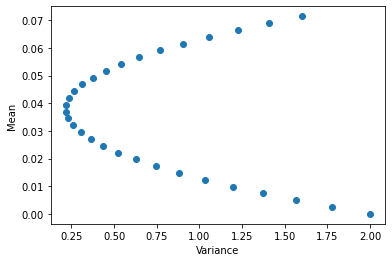

In [14]:
#|echo: false

# plot var vs mean

fig = plt.figure()
ax = plt.subplot()
plt.scatter(ens_var, ens_mean)
ax.set_xlabel('Variance')
ax.set_ylabel('Mean')
plt.show()

With the previous 50:50 split the variance seems almost at the lowest point. So we only get a reduction of the mean below 0.0357 if we allow the ensemble to have more variance, hence take more risk.

# 2. Weights by residual variance

Since the Model 1 and Model 2 are well fitted, their average residuals are pretty close to 0. So let's focus on reducing our variance to avoid surprises on later later predictions.

We now solve for the optimal weights that minimizes the variance of the residual of our ensemble with this function:

In [15]:
fun = lambda w: (y_true-np.matmul(w, preds)).var()

We also define a constraint so that the `w.sum() == 0`:

In [16]:
# w.sum() = 1  <=> 0 = w.sum()-1
cons = ({'type': 'eq', 'fun': lambda w: w.sum()-1})

If you want, you can also set bounds, so that the weights want be negative.

I don't. I like the idea of going *short* with a model. And negative weights really increase the results of TPS predictions in chapter 4. 

In [17]:
bnds = ((0,None),
        (0,None),
        (0,None),
        (0,None),
        (0,None))

Now, we are all set to retrieve the optimal weights. 

In [18]:
# predictions of Model1 and Model 2
preds = np.array([m1, m2])

# init weights
w_init = np.ones(preds.shape[0])/preds.shape[0]

# run optimization
res = scipy.optimize.minimize(fun, w_init, method='SLSQP',  constraints=cons) #,bounds=bnds

# get optimal weights
w_calc = res.x


print(f'Calculated weights: {w_calc}')

Calculated weights: [0.53150242 0.46849758]


Let's see how the calculated weights perform.

In [19]:
ens_ex1 = np.matmul(w_calc, preds)
ens_ex1_res=y_true-ens_ex1

print(f'Ensemble Ex1. mean: {ens_ex1_res.mean(): .4f}, var: {ens_ex1_res.var(): .4f}')

Ensemble Ex1. mean:  0.0380, var:  0.2157


We con compare the results with the first ensemble 50:50 split. 
With the calculated weights we could further reduce the variance of the model (0.2219 -> 0.2157). But unfortunately the mean increased a bit (0.0357 -> 0.0380).

We see the trade off between mean and variance and have to decide if we prefer a more stable model or take some risk for better results.

# 3. Portfolio theory for ensembling

In finance different assets are often combined in a portfolio. There are many criteria for the asset selection/allocation. One of them is by choosing a risk strategy. In 1952 the economist Harry Markowitz defined a *Portfolio Selection* strategy which built the foundation of many portfolio strategies to come. There is a great summary on [Wikipidia](https://en.wikipedia.org/wiki/Modern_portfolio_theory), but the original paper can also be found with a google search.


So, what it is all about. Let's assume we are living in an easy, plain vanilla world. We want to build a portfolio that yields high return with low risk. That's not easy. If we only buy stocks of our favorite fruit grower, a rainy summer would result in a low return. Wouldn't it be smart to also buy stocks of a raincoat producer, just in case. But what if the summer was sunny, then we would have rather invested the entire money in fruits instead of raincoats. It's clearly a trade off. Either we lower the risk of loosing money in a rainy summer and invest in both (fruits and raincoats). Or we take the risk investing all money in fruits to maybe gain more money. And if we lower the risk, in which raincoat producer should we invest? The one with the bumpy stock price or the one with a steady, but slowly growing stock price.

Now, we already see the first similarities between our ensemble example above and the Portfolio Theory. Risk can be measured through variance and a good return of our ensemble is results in a low expected residual.

But there is even more in Portfolio Theory. It also takes dependencies between assets into account. If the summer is sunny the fruit price goes up and the raincoat price goes down, they are somewhat negative correlated. 

Since we expect the average residual of our fitted models to be close to 0 and we build a linear model, we can expect our ensemble average residual also to be close to 0. Therefore, we focus on optimizing the portfolio variance, which can be boiled down to `Var_p = w'*Cov*w`. The covariance measures the dependency between combined models and also considers the variance.

> What data can we actually use? In the financial example *returns* are the increase or decrease of an asset price (p/p_t-1), hence we are looking on returns for a certain period of time. In ML we can take our **out-of-fold** (oof) predictions and calculate the residuals from the train targets to build a dataset.

> Can we do this despite we are looking at a time-series in the financial example? Yes, in this *basic* portfolio theory we don't take time dependencies into account. But it's important to keep the same order for the different asset returns for correlation/covariance calculation. We want to compare the residual of model 1 and 2 for always the same data item.

The optimization function for the second ensemble technique is:

In [20]:
## following https://en.wikipedia.org/wiki/Modern_portfolio_theory

# Predictions of Model 1 and Model 2
preds = np.array([m1,m2])
# Residuals of Model 1 and Model 2
preds_res = np.array([m1_res, m2_res])

# handle residuals like asset returns
R = np.array(preds_res.mean(axis=1))
# factor by which R is considered during optimization. turned off for our example
q = 0 #-1

# covariance matrix of model residuals
CM = np.cov(preds_res)

# optimization function
fun = lambda w: np.matmul(np.matmul(w.T,CM),w) - q * np.matmul(R,w)

# constraint: weights must sum up to 1.0
cons = ({'type': 'eq', 'fun': lambda x: x.sum()-1})

Run the optimization.

In [21]:
# init weights
w_init = np.ones(preds.shape[0])/preds.shape[0]

# run optimization
res = scipy.optimize.minimize(fun, w_init, method='SLSQP',  constraints=cons) #,bounds=bnds

# get optimal weights
w_calc = res.x

print(f'Calculated weights: {w_calc}')

Calculated weights: [0.53150242 0.46849758]


The weights are the same as in the first technique. That really surprised me. And I run a couple of examples with different models. But the weights were only slightly different between the two techniques.

In [22]:
#|include: false

ens_ex2 = np.matmul(w_calc, preds)
ens_ex2_res=y_true-ens_ex2
ens_ex2_res.mean(), ens_ex2_res.var()

(0.0379644588251949, 0.21567043618739917)

# 4. Ensembling TPS Aug 2021

Now that we have to techniques to ensemble, let's try them on the [TPS August 2021](https://www.kaggle.com/c/tabular-playground-series-aug-2021/overview) data.

We do a 7 kfold split and calculate the residuals on the out-of-fold-predictions, that are used for validation. We train 7 regression models with different architecture so we get some diversity.

In [23]:
N_SPLITS = 7
SEED = 2021

PATH_INPUT = '/home/kaggle/TPS-AUG-2021/input/'

In [24]:
# load and shuffle
test = pd.read_csv(PATH_INPUT + 'test.csv')

train = pd.read_csv(PATH_INPUT + 'train.csv').sample(frac=1.0, random_state = SEED).reset_index(drop=True)

train['fold_crit'] = train.loss
train.loc[train.loss>=39, 'fold_crit']=39


In [25]:
target = 'loss'
fold_crit = 'fold_crit'
features = list(set(train.columns)-set(['id','kfold','loss','fold_crit']+[target]))

In [26]:
# apply abhisheks splitting technique
skf = StratifiedKFold(n_splits = N_SPLITS, random_state = None, shuffle = False)

train.kfold = -1

for f, (train_idx, valid_idx) in enumerate(skf.split(X = train, y = train[fold_crit].values)):
    
    train.loc[valid_idx,'kfold'] = f

train.groupby('kfold')[target].count()

kfold
0.0    35715
1.0    35715
2.0    35714
3.0    35714
4.0    35714
5.0    35714
6.0    35714
Name: loss, dtype: int64

In [27]:
# define models
models = {
    'LinReg': LinearRegression(n_jobs=-1),
    'HGB': HistGradientBoostingRegressor(),
    'XGB': XGBRegressor(tree_method = 'gpu_hist', reg_lambda= 6, reg_alpha= 10, n_jobs=-1),
    'KNN': KNeighborsRegressor(100, n_jobs=-1),
    'BayesRidge': BayesianRidge(),
    'ExtraTrees': ExtraTreesRegressor(max_depth=2, n_jobs=-1),
    'Poisson': Pipeline(steps=[('scale', StandardScaler()),
                ('pois', PoissonRegressor(max_iter=100))])    
}



In [28]:
#|include: false

#for (k, model) in models.items():
#    scores = cross_val_score(model, train[features], train[target], n_jobs=-1, cv=skf, scoring='neg_root_mean_squared_error')
#    print(f'{k}:\t {-scores.mean():0.5f} (+/- {scores.std():0.5f}) rmse')

Fit models and save oof predictions.

In [29]:
for (m_name, m) in models.items():
    print(f'# Model:{m_name}\n')
    train[m_name + '_oof'] = 0
    test[m_name] = 0
    
    y_oof = np.zeros(train.shape[0])
    
    for f in range(N_SPLITS):

        train_df = train[train['kfold'] != f]
        valid_df = train[train['kfold'] == f]
        
        m.fit(train_df[features], train_df[target])
        
        oof_preds = m.predict(valid_df[features])
        y_oof[valid_df.index] = oof_preds
        print(f'Fold {f} rmse: {mean_squared_error(valid_df[target], oof_preds, squared = False):0.5f}')
        
        test[m_name] += m.predict(test[features]) / N_SPLITS
    
    train[m_name + '_oof'] = y_oof
    
    print(f"\nTotal rmse: {mean_squared_error(train[target], train[m_name + '_oof'], squared = False):0.5f}\n")


oof_cols = [m_name + '_oof' for m_name in models.keys()]

print(f"# ALL Mean ensemble rmse: {mean_squared_error(train[target], train[oof_cols].mean(axis=1), squared = False):0.5f}\n")        

# Model:LinReg

Fold 0 rmse: 7.89515
Fold 1 rmse: 7.90212
Fold 2 rmse: 7.90260
Fold 3 rmse: 7.89748
Fold 4 rmse: 7.89844
Fold 5 rmse: 7.89134
Fold 6 rmse: 7.89643

Total rmse: 7.89765

# Model:HGB

Fold 0 rmse: 7.86447
Fold 1 rmse: 7.87374
Fold 2 rmse: 7.86688
Fold 3 rmse: 7.86255
Fold 4 rmse: 7.86822
Fold 5 rmse: 7.85785
Fold 6 rmse: 7.86566

Total rmse: 7.86563

# Model:XGB

Fold 0 rmse: 7.91179
Fold 1 rmse: 7.92748
Fold 2 rmse: 7.92141
Fold 3 rmse: 7.91901
Fold 4 rmse: 7.91125
Fold 5 rmse: 7.90286
Fold 6 rmse: 7.92340

Total rmse: 7.91675

# Model:KNN

Fold 0 rmse: 7.97845
Fold 1 rmse: 7.97709
Fold 2 rmse: 7.98165
Fold 3 rmse: 7.97895
Fold 4 rmse: 7.97781
Fold 5 rmse: 7.97798
Fold 6 rmse: 7.98711

Total rmse: 7.97986

# Model:BayesRidge

Fold 0 rmse: 7.89649
Fold 1 rmse: 7.90576
Fold 2 rmse: 7.90349
Fold 3 rmse: 7.90007
Fold 4 rmse: 7.90121
Fold 5 rmse: 7.89455
Fold 6 rmse: 7.89928

Total rmse: 7.90012

# Model:ExtraTrees

Fold 0 rmse: 7.93239
Fold 1 rmse: 7.93247
Fold 2 rmse: 7.929

In [30]:
#|include: false

test

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f97,f98,f99,LinReg,HGB,XGB,KNN,BayesRidge,ExtraTrees,Poisson
0,250000,0.812665,15,-1.239120,-0.893251,295.5770,15.87120,23.04360,0.942256,29.898000,...,0.529470,1.386950,8.78767,7.345237,7.602135,7.705725,7.255714,7.586199,6.789588,7.268488
1,250001,0.190344,131,-0.501361,0.801921,64.8866,3.09703,344.80500,0.807194,38.421900,...,0.248534,0.863881,11.79390,5.376716,5.229485,4.805800,6.158571,5.601824,6.766983,5.630479
2,250002,0.919671,19,-0.057382,0.901419,11961.2000,16.39650,273.24000,-0.003300,37.940000,...,0.931796,2.336870,9.05400,7.651249,7.420569,8.540191,7.122857,7.673041,6.775451,7.524152
3,250003,0.860985,19,-0.549509,0.471799,7501.6000,2.80698,71.08170,0.792136,0.395235,...,0.893348,1.359470,4.84833,6.661025,7.372555,7.524225,6.924286,6.769112,6.825774,6.652484
4,250004,0.313229,89,0.588509,0.167705,2931.2600,4.34986,1.57187,1.118300,7.754630,...,0.361923,1.532800,3.70660,7.381046,7.705069,7.129917,6.142857,7.349137,6.900829,7.300795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,399995,0.751053,77,0.666725,-1.106280,21433.3000,16.58120,122.77900,-0.319314,-82.222900,...,0.358354,1.434990,8.55460,8.170482,7.246772,6.661339,6.524286,7.960342,6.792668,8.062418
149996,399996,0.734669,41,0.611225,0.740177,294.1850,10.72900,25.03340,0.644556,-13.998000,...,0.563482,1.872810,12.54960,7.208572,7.049250,7.353537,6.194286,7.097409,6.816994,7.139650
149997,399997,0.417307,142,-0.357854,-0.836640,1215.2500,10.62460,221.60400,0.875104,-41.531500,...,0.288236,2.323660,12.33840,6.554256,6.223466,6.115452,7.187143,6.356866,6.771077,6.560769
149998,399998,1.023900,17,0.367100,-0.936674,1832.3900,8.51691,262.79700,-0.474002,7.162060,...,0.453850,1.653140,31.16380,6.338662,5.767323,4.304114,5.804286,6.458786,6.817902,6.392916


Let's a look at the correlation heatmap.

<AxesSubplot:>

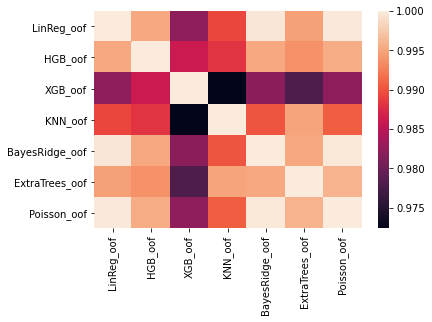

In [31]:

oof_cols = [m_name + '_oof' for m_name in models.keys()]

oofs = train[oof_cols]

oof_diffs = oofs.copy()
for c in oof_cols:
    oof_diffs[c] = oofs[c]-train[target]
    oof_diffs[c] = oof_diffs[c]#**2

sns.heatmap(oof_diffs.corr())

XGB and KNN are most diverse, so I export a 50:50 ensemble. I'll also export an equally weighted ensemble of all models and HGB only because it is the best single model.

In [32]:
#|echo: false

# Do some manual equaly wheighted ensemblings and export.

submission = pd.read_csv(PATH_INPUT + 'sample_submission.csv')
submission['loss']=test[models.keys()].mean(axis=1)

submission.to_csv('submission_ALL.csv',index=False)
print('CV: ALL equaly weighted:',mean_squared_error(train[target], train[[m_name + '_oof' for m_name in models.keys()]].mean(axis=1), squared = False))

submission['loss']=test[['XGB']].mean(axis=1)

submission.to_csv('submission_xgb.csv',index=False)
print('CV: XGB only:',mean_squared_error(train[target], train[['XGB_oof']].mean(axis=1), squared = False))

submission['loss']=test[['HGB']].mean(axis=1)

submission.to_csv('submission_hgb.csv',index=False)
print('CV: HGB only:',mean_squared_error(train[target], train[['HGB_oof']].mean(axis=1), squared = False))

submission['loss']=test[['LinReg', 'XGB']].mean(axis=1)

submission.to_csv('submission_xgb_lin.csv',index=False)
print('CV: XGB and LinReg (50:50):',mean_squared_error(train[target], train[['LinReg_oof', 'XGB_oof']].mean(axis=1), squared = False))

submission['loss']=test[['KNN', 'XGB']].mean(axis=1)

submission.to_csv('submission_xgb_knn.csv',index=False)
print('CV: XGB and KNN (50:50):',mean_squared_error(train[target], train[['KNN_oof', 'XGB_oof']].mean(axis=1), squared = False))


CV: ALL equaly weighted: 7.880605075536334
CV: XGB only: 7.916746570344035
CV: HGB only: 7.865625158180185
CV: XGB and LinReg (50:50): 7.872064005057903
CV: XGB and KNN (50:50): 7.893210466099108


Next we inspect the variance and mean of the residuals. Means are close to 0, as expected.

In [33]:
oof_diffs.var(), oof_diffs.mean()

(LinReg_oof        62.373163
 HGB_oof           61.868296
 XGB_oof           62.675125
 KNN_oof           63.678431
 BayesRidge_oof    62.412188
 ExtraTrees_oof    62.915511
 Poisson_oof       62.377910
 dtype: float64,
 LinReg_oof       -0.000055
 HGB_oof          -0.003314
 XGB_oof           0.001392
 KNN_oof          -0.005395
 BayesRidge_oof   -0.000024
 ExtraTrees_oof   -0.000136
 Poisson_oof      -0.000084
 dtype: float64)

These are the histograms of the residuals:

array([[<AxesSubplot:title={'center':'LinReg_oof'}>,
        <AxesSubplot:title={'center':'HGB_oof'}>,
        <AxesSubplot:title={'center':'XGB_oof'}>],
       [<AxesSubplot:title={'center':'KNN_oof'}>,
        <AxesSubplot:title={'center':'BayesRidge_oof'}>,
        <AxesSubplot:title={'center':'ExtraTrees_oof'}>],
       [<AxesSubplot:title={'center':'Poisson_oof'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

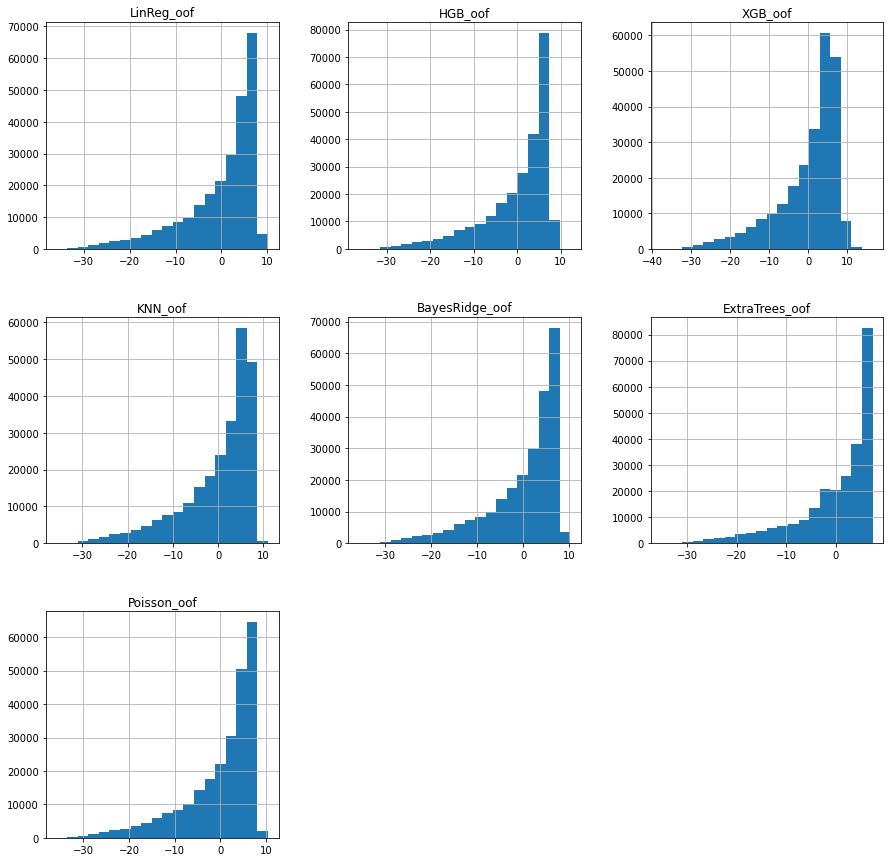

In [34]:
#|echo: false

oof_diffs.hist(figsize=(15,15),bins=20)

Finally, we apply the two techniques to calculate the ensembling weights

In [35]:
R = oof_diffs.mean().values
CM = oof_diffs.cov().values

q=0

# Var technique
fun_ex1 = lambda w: (train[target]-np.matmul(oofs.values, w)).var()
# Cov technique
fun_ex2 = lambda w: np.matmul(np.matmul(w.T,CM),w) - q * np.matmul(R,w)

cons = ({'type': 'eq', 'fun': lambda x: x.sum()-1})

bnds = ((0,None),
        (0,None),
        (0,None),
        (0,None),
        (0,None))

In [36]:
# Example 1

w_init = np.ones((len(models)))/len(models)

res = scipy.optimize.minimize(fun_ex1, w_init, method='SLSQP',  constraints=cons) #,bounds=bnds

w_calc = res.x

In [37]:
#|echo: false

submission['loss']=(test[models.keys()]*w_calc).sum(axis=1)

submission.to_csv('submission_ex1_w_calc.csv',index=False)

print('CV: Ex1 calc weights:',mean_squared_error(train[target], (train[[m_name + '_oof' for m_name in models.keys()]]*w_calc).sum(axis=1), squared = False))

CV: Ex1 calc weights: 7.85594426240217


In [38]:
# Example 2

w_init = np.ones((len(models)))/len(models)

res = scipy.optimize.minimize(fun_ex2, w_init, method='SLSQP',  constraints=cons) #,bounds=bnds

w_calc = res.x

In [39]:
#|echo: false

submission['loss']=(test[models.keys()]*w_calc).sum(axis=1)

submission.to_csv('submission_ex2_w_calc.csv',index=False)

print('CV: Ex2 calc weights:',mean_squared_error(train[target], (train[[m_name + '_oof' for m_name in models.keys()]]*w_calc).sum(axis=1), squared = False))

CV: Ex2 calc weights: 7.855944262936231


# 5. Results

The competition metric is root mean squared error (RMSE). These are the scores of the different ensembles:

|Ensemble|     CV|public LB|
|--------|-------|---------|
|HGB only|7.86563|7.90117|
|All weights eq.|7.88061|7.92183|
|XGB and KNN (50:50)| 7.89321|7.91603|
|Ex1 (Var)| 7.85594|7.88876|
|Ex2 (Cov)| 7.85594|7.88876|

# References

- Modern Portfolio Theory: https://en.wikipedia.org/wiki/Modern_portfolio_theory
- TPS August 2021 Competition: https://www.kaggle.com/c/tabular-playground-series-aug-2021/overview

# Ressources
- Original notebook: https://www.kaggle.com/joatom/model-allocation
- TPS data: https://www.kaggle.com/c/tabular-playground-series-aug-2021/data